Import & Setup

In [63]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from IPython.display import Audio, display, Image
from music21 import stream, note, tempo, meter, environment, tie, converter, metadata
import os


MuseScore & Output Folder Configuration

In [64]:
env = environment.UserSettings()
env['musescoreDirectPNGPath'] = os.path.abspath("MuseScorePortable/App/MuseScore/bin/MuseScore4.exe")
env['musicxmlPath'] = os.path.abspath("MuseScorePortable/App/MuseScore/bin/MuseScore4.exe")

os.makedirs("output", exist_ok=True)


Utility Notes & Durations

In [65]:
# Konversi simbol nada dari format Librosa ke Music21
def convert_librosa_note_to_music21(note_name):
    if note_name is None:
        return None
    return note_name.replace('♯', '#').replace('♭', 'b')

# Kuantisasi durasi supaya sesuai notasi musik standar (e.g. 1.0 = Quarter, 0.5 = Eighth)
def quantize_duration(dur):
    valid_quarter_lengths = [4, 3, 2, 1.5, 1, 0.75, 0.5, 0.25, 0.125]
    midpoint = ((0.125 + 0.0625) / 2)
    if dur < midpoint:
        return 0.0
    closest = min(valid_quarter_lengths, key=lambda x: abs(x - dur))
    return closest

# Ubah durasi kuantisasi ke istilah musik formal
def get_duration_name(duration):
    names = {
        4.0: "Semibreve / Whole (4 ketuk)",
        3.0: "Dotted Minim (3 ketuk)",
        2.0: "Minim / Half (2 ketuk)",
        1.5: "Dotted Crotchet (3/2 ketuk)",
        1.0: "Crotchet / Quarter (1 ketuk)",
        0.75: "Dotted Quaver (3/4 ketuk)",
        0.5: "Quaver / Eighth (1/2 ketuk)",
        0.25: "Semiquaver / Sixteenth (1/4 ketuk)",
        0.125: "Demisemiquaver / Thirty-second (1/8 ketuk)",
    }
    return names.get(duration, f"{duration:.2f} ketuk")


Audio & Tempo Processing

In [66]:
def load_and_analyze_audio(audio_path):
    # Membaca file audio dan mengembalikan waveform (y) dan sample rate (sr)
    y, sr = librosa.load(audio_path, sr=None, mono=True)

    # Menggunakan pYIN (probabilistic YIN) untuk mendeteksi pitch (f0) tiap frame
    f0, _, _ = librosa.pyin(
        y,
        fmin=librosa.note_to_hz('C2'),
        fmax=librosa.note_to_hz('C7'),
        frame_length=2048,
        hop_length=512,
        sr=sr
    )

    # Menghitung waktu (dalam detik) untuk setiap frame pitch yang terdeteksi
    times = librosa.times_like(f0, sr=sr, hop_length=512)

    return y, sr, f0, times


# Estimasi tempo musik (BPM) menggunakan onset strength
def estimate_tempo(y, sr, fallback_bpm=90):
    # mendeteksi kekuatan onset per waktu berdasarkan beat
    onset_env = librosa.onset.onset_strength(y=y, sr=sr)

    # estimasi tempo dalam BPMdari onset envelope
    try:
        tempo_candidates = librosa.feature.rhythm.tempo(onset_envelope=onset_env, sr=sr, aggregate=None)
    except AttributeError:
        tempo_candidates = librosa.beat.tempo(onset_envelope=onset_env, sr=sr, aggregate=None)

    if tempo_candidates is None or len(tempo_candidates) == 0:
        return fallback_bpm

    estimated = tempo_candidates[0]

    # tempo correction if terlalu cepat/lambat
    if estimated > 180:
        estimated /= 2
    elif estimated < 60:
        estimated *= 2
    return round(estimated)


Notes & Rest Detection

In [67]:
# Deteksi notes & rests dari hasil pitch tracking (f0)
# dan ubah ke durasi dalam "quarter length" (notasi musik)
# tapi deteksi rests tidak berfungsi
def detect_notes_with_rests(f0, times, bpm, min_duration_ql=0.125):
    notes = []
    current_pitch = None
    start_time = 0
    last_end_time = 0
    ql_per_second = bpm / 60

    for i in range(len(f0)):
        if not np.isnan(f0[i]): # diproses jika pitch terdeteksi
            detected_hz = f0[i]

            # frekuensi correction supaya dalam rentang C3–C6 tidak terlalu tinggi atau rendah
            min_hz = librosa.note_to_hz('C4')
            max_hz = librosa.note_to_hz('C5')
            while detected_hz < min_hz: detected_hz *= 2
            while detected_hz > max_hz: detected_hz /= 2

            # note name conversion (misalnya: A4, C#5, dst)
            note_name = convert_librosa_note_to_music21(librosa.hz_to_note(detected_hz))

            # Awal note baru (belum ada pitch sebelumnya)
            if current_pitch is None:
                # If sebelumnya adalah null, coba deteksi rest
                if last_end_time > 0:
                    gap = times[i] - last_end_time
                    gap_ql = gap * ql_per_second
                    rest_dur = quantize_duration(gap_ql)
                    if rest_dur >= min_duration_ql:
                        notes.append(('rest', None, last_end_time, rest_dur))
                current_pitch = note_name
                start_time = times[i]

            # If pitch changes, then note sebelumnya selesai, mulai note baru
            elif note_name != current_pitch:
                dur_sec = times[i] - start_time
                dur_ql = dur_sec * ql_per_second
                dur_q = quantize_duration(dur_ql)
                if dur_q >= min_duration_ql:
                    notes.append(('note', current_pitch, start_time, dur_q))
                    last_end_time = times[i]
                current_pitch = note_name
                start_time = times[i]

    # Untuk note terakhir di akhir file audio, sebenarnya tidak berguna
    if current_pitch is not None:
        dur_sec = times[-1] - start_time
        dur_ql = dur_sec * ql_per_second
        dur_q = quantize_duration(dur_ql)
        if dur_q >= min_duration_ql:
            notes.append(('note', current_pitch, start_time, dur_q))

    return notes


Generating Stream Object

In [68]:
# Buat stream partitur dengan birama dan tie
# Tie digunakan saat durasi not melebihi sisa birama, lalu dibagi ke birama selanjutnya
def create_measured_stream(note_list, bpm=120, time_sig='4/4', title=None):
    s = stream.Stream()
    s.append(tempo.MetronomeMark(number=bpm))
    s.append(meter.TimeSignature(time_sig))

    if title:
        s.metadata = metadata.Metadata()
        s.metadata.title = title

    s.append(tempo.MetronomeMark(number=bpm))
    s.append(meter.TimeSignature(time_sig))

    current_measure = stream.Measure(number=1)
    remaining = 4.0

    for n in note_list:
        typ, pitch, start, dur = n
        dur_left = dur
        is_tied = False  # tanda ini not panjang yang dipecah

        while dur_left > 0:
            use_dur = min(dur_left, remaining)

            if typ == 'note':
                m21_note = note.Note(pitch)
                m21_note.duration.quarterLength = use_dur

                # Tie
                if is_tied:
                    if dur_left == dur:
                        m21_note.tie = tie.Tie('continue')
                    elif dur_left - use_dur <= 0.001:
                        m21_note.tie = tie.Tie('stop')
                    else:
                        m21_note.tie = note.Tie('continue')
                elif dur_left - use_dur > 0.001:
                    m21_note.tie = tie.Tie('start')
                    is_tied = True

                current_measure.append(m21_note)
            else: # menambah rest jika bukan not
                m21_rest = note.Rest()
                m21_rest.duration.quarterLength = use_dur
                current_measure.append(m21_rest)

            remaining -= use_dur
            dur_left -= use_dur

            # If birama habis, then mulai birama baru
            if remaining <= 0.001:
                s.append(current_measure)
                current_measure = stream.Measure(number=len(s) + 1)
                remaining = 4.0

    if len(current_measure) > 0:
        s.append(current_measure)

    s.makeBeams(inPlace=True)
    return s


Visualization, Output & Execution

In [69]:
import os

# Simpan hasil analisis ke folder berdasarkan nama file audio
# Termasuk MIDI, MusicXML, dan PNG
def process_audio_to_sheet_music(audio_path):
    y, sr, f0, times = load_and_analyze_audio(audio_path)
    bpm = estimate_tempo(y, sr)
    notes = detect_notes_with_rests(f0, times, bpm=bpm)

    if not notes:
        print("Tidak ada nada terdeteksi.")
        return None

    print("Daftar Nada Terdeteksi:")
    for idx, n in enumerate(notes, 1):
        dur_name = get_duration_name(n[3])
        if n[0] == 'note':
            print(f"{idx}. Nada {n[1]}, {dur_name}")
        elif n[0] == 'rest':
            print(f"{idx}. Istirahat, {dur_name}")

    # Buat file & folder Output
    filename = os.path.basename(audio_path)  # "Cicak - Cicak.wav"
    name_safe = os.path.splitext(filename)[0]
    output_dir = os.path.join("output", name_safe)
    os.makedirs(output_dir, exist_ok=True)

    # buat music sheet
    score = create_measured_stream(notes, bpm, title=name_safe)



    # Buat chart nada & durasi
    plt.figure(figsize=(14, 5))
    for n in notes:
        if n[0] == 'note':
            plt.hlines(y=librosa.note_to_hz(n[1]),
                       xmin=n[2],
                       xmax=n[2] + (n[3] * 60 / bpm),
                       linewidth=10, colors='b')
    plt.yscale('log')
    plt.title('Detected Notes')
    plt.xlabel('Time (s)')
    plt.ylabel('Pitch (Hz)')
    plt.show()

    # MIDI
    midi_path = os.path.join(output_dir, f"{name_safe}.mid")
    score.write('midi', fp=midi_path)
    print(f"Disimpan ke {midi_path}")

    # MusicXML
    xml_path = os.path.join(output_dir, f"{name_safe}.musicxml")
    try:
        score.write('musicxml', fp=xml_path)
        print(f"Disimpan ke {xml_path}")
    except Exception as e:
        print("Gagal menyimpan MusicXML:", e)

    # PNG tapi nggak bisa
    try:
        png_path = os.path.join(output_dir, f"{name_safe}.png")
        score.write('musicxml.png', fp=png_path)
        print(f"Partitur gambar disimpan di {png_path}")
        display(Image(filename=png_path))
    except Exception as e:
        print("Gagal menyimpan partitur sebagai gambar:", e)

    return score


Main Execution

Daftar Nada Terdeteksi:
1. Nada E4, Dotted Quaver (3/4 ketuk)
2. Nada F4, Dotted Quaver (3/4 ketuk)
3. Nada C4, Crotchet / Quarter (1 ketuk)
4. Nada C4, Minim / Half (2 ketuk)
5. Nada E4, Quaver / Eighth (1/2 ketuk)
6. Nada C4, Semibreve / Whole (4 ketuk)
7. Nada D4, Quaver / Eighth (1/2 ketuk)
8. Nada E4, Quaver / Eighth (1/2 ketuk)
9. Nada F4, Crotchet / Quarter (1 ketuk)
10. Nada D4, Crotchet / Quarter (1 ketuk)
11. Nada G4, Crotchet / Quarter (1 ketuk)
12. Nada F4, Dotted Crotchet (3/2 ketuk)
13. Nada C4, Semibreve / Whole (4 ketuk)
14. Nada C4, Quaver / Eighth (1/2 ketuk)
15. Nada A#4, Demisemiquaver / Thirty-second (1/8 ketuk)
16. Nada F4, Crotchet / Quarter (1 ketuk)
17. Nada A4, Crotchet / Quarter (1 ketuk)
18. Nada B4, Quaver / Eighth (1/2 ketuk)
19. Nada A#4, Demisemiquaver / Thirty-second (1/8 ketuk)
20. Nada A#4, Demisemiquaver / Thirty-second (1/8 ketuk)
21. Nada B4, Semiquaver / Sixteenth (1/4 ketuk)
22. Nada A#4, Demisemiquaver / Thirty-second (1/8 ketuk)
23. Nada C5, Do

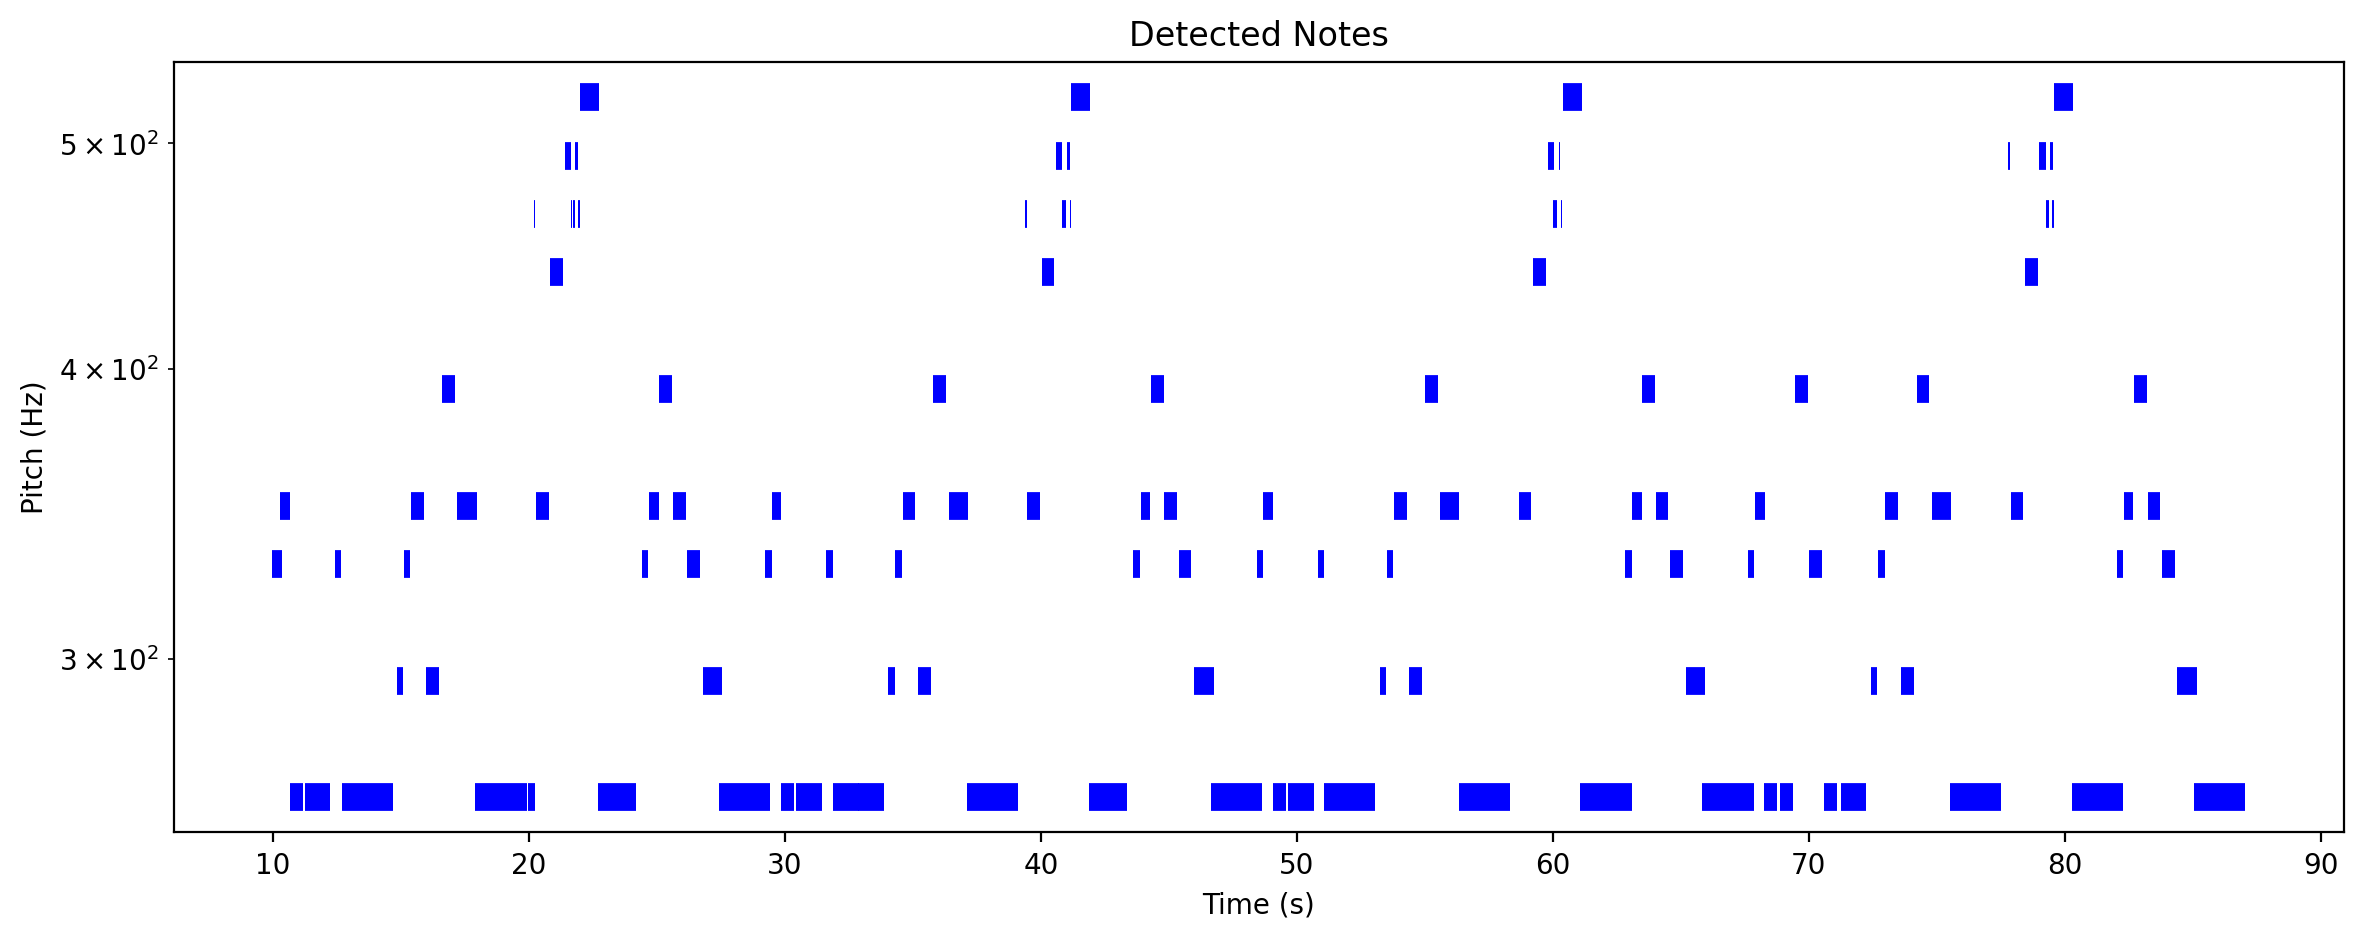

Disimpan ke output\not piano balonku - tutorial piano tingkat 1 - lagu anak anak ciptaan at mahmud\not piano balonku - tutorial piano tingkat 1 - lagu anak anak ciptaan at mahmud.mid
Disimpan ke output\not piano balonku - tutorial piano tingkat 1 - lagu anak anak ciptaan at mahmud\not piano balonku - tutorial piano tingkat 1 - lagu anak anak ciptaan at mahmud.musicxml
Partitur gambar disimpan di output\not piano balonku - tutorial piano tingkat 1 - lagu anak anak ciptaan at mahmud\not piano balonku - tutorial piano tingkat 1 - lagu anak anak ciptaan at mahmud.png
Gagal menyimpan partitur sebagai gambar: [Errno 2] No such file or directory: 'output\\not piano balonku - tutorial piano tingkat 1 - lagu anak anak ciptaan at mahmud\\not piano balonku - tutorial piano tingkat 1 - lagu anak anak ciptaan at mahmud.png'


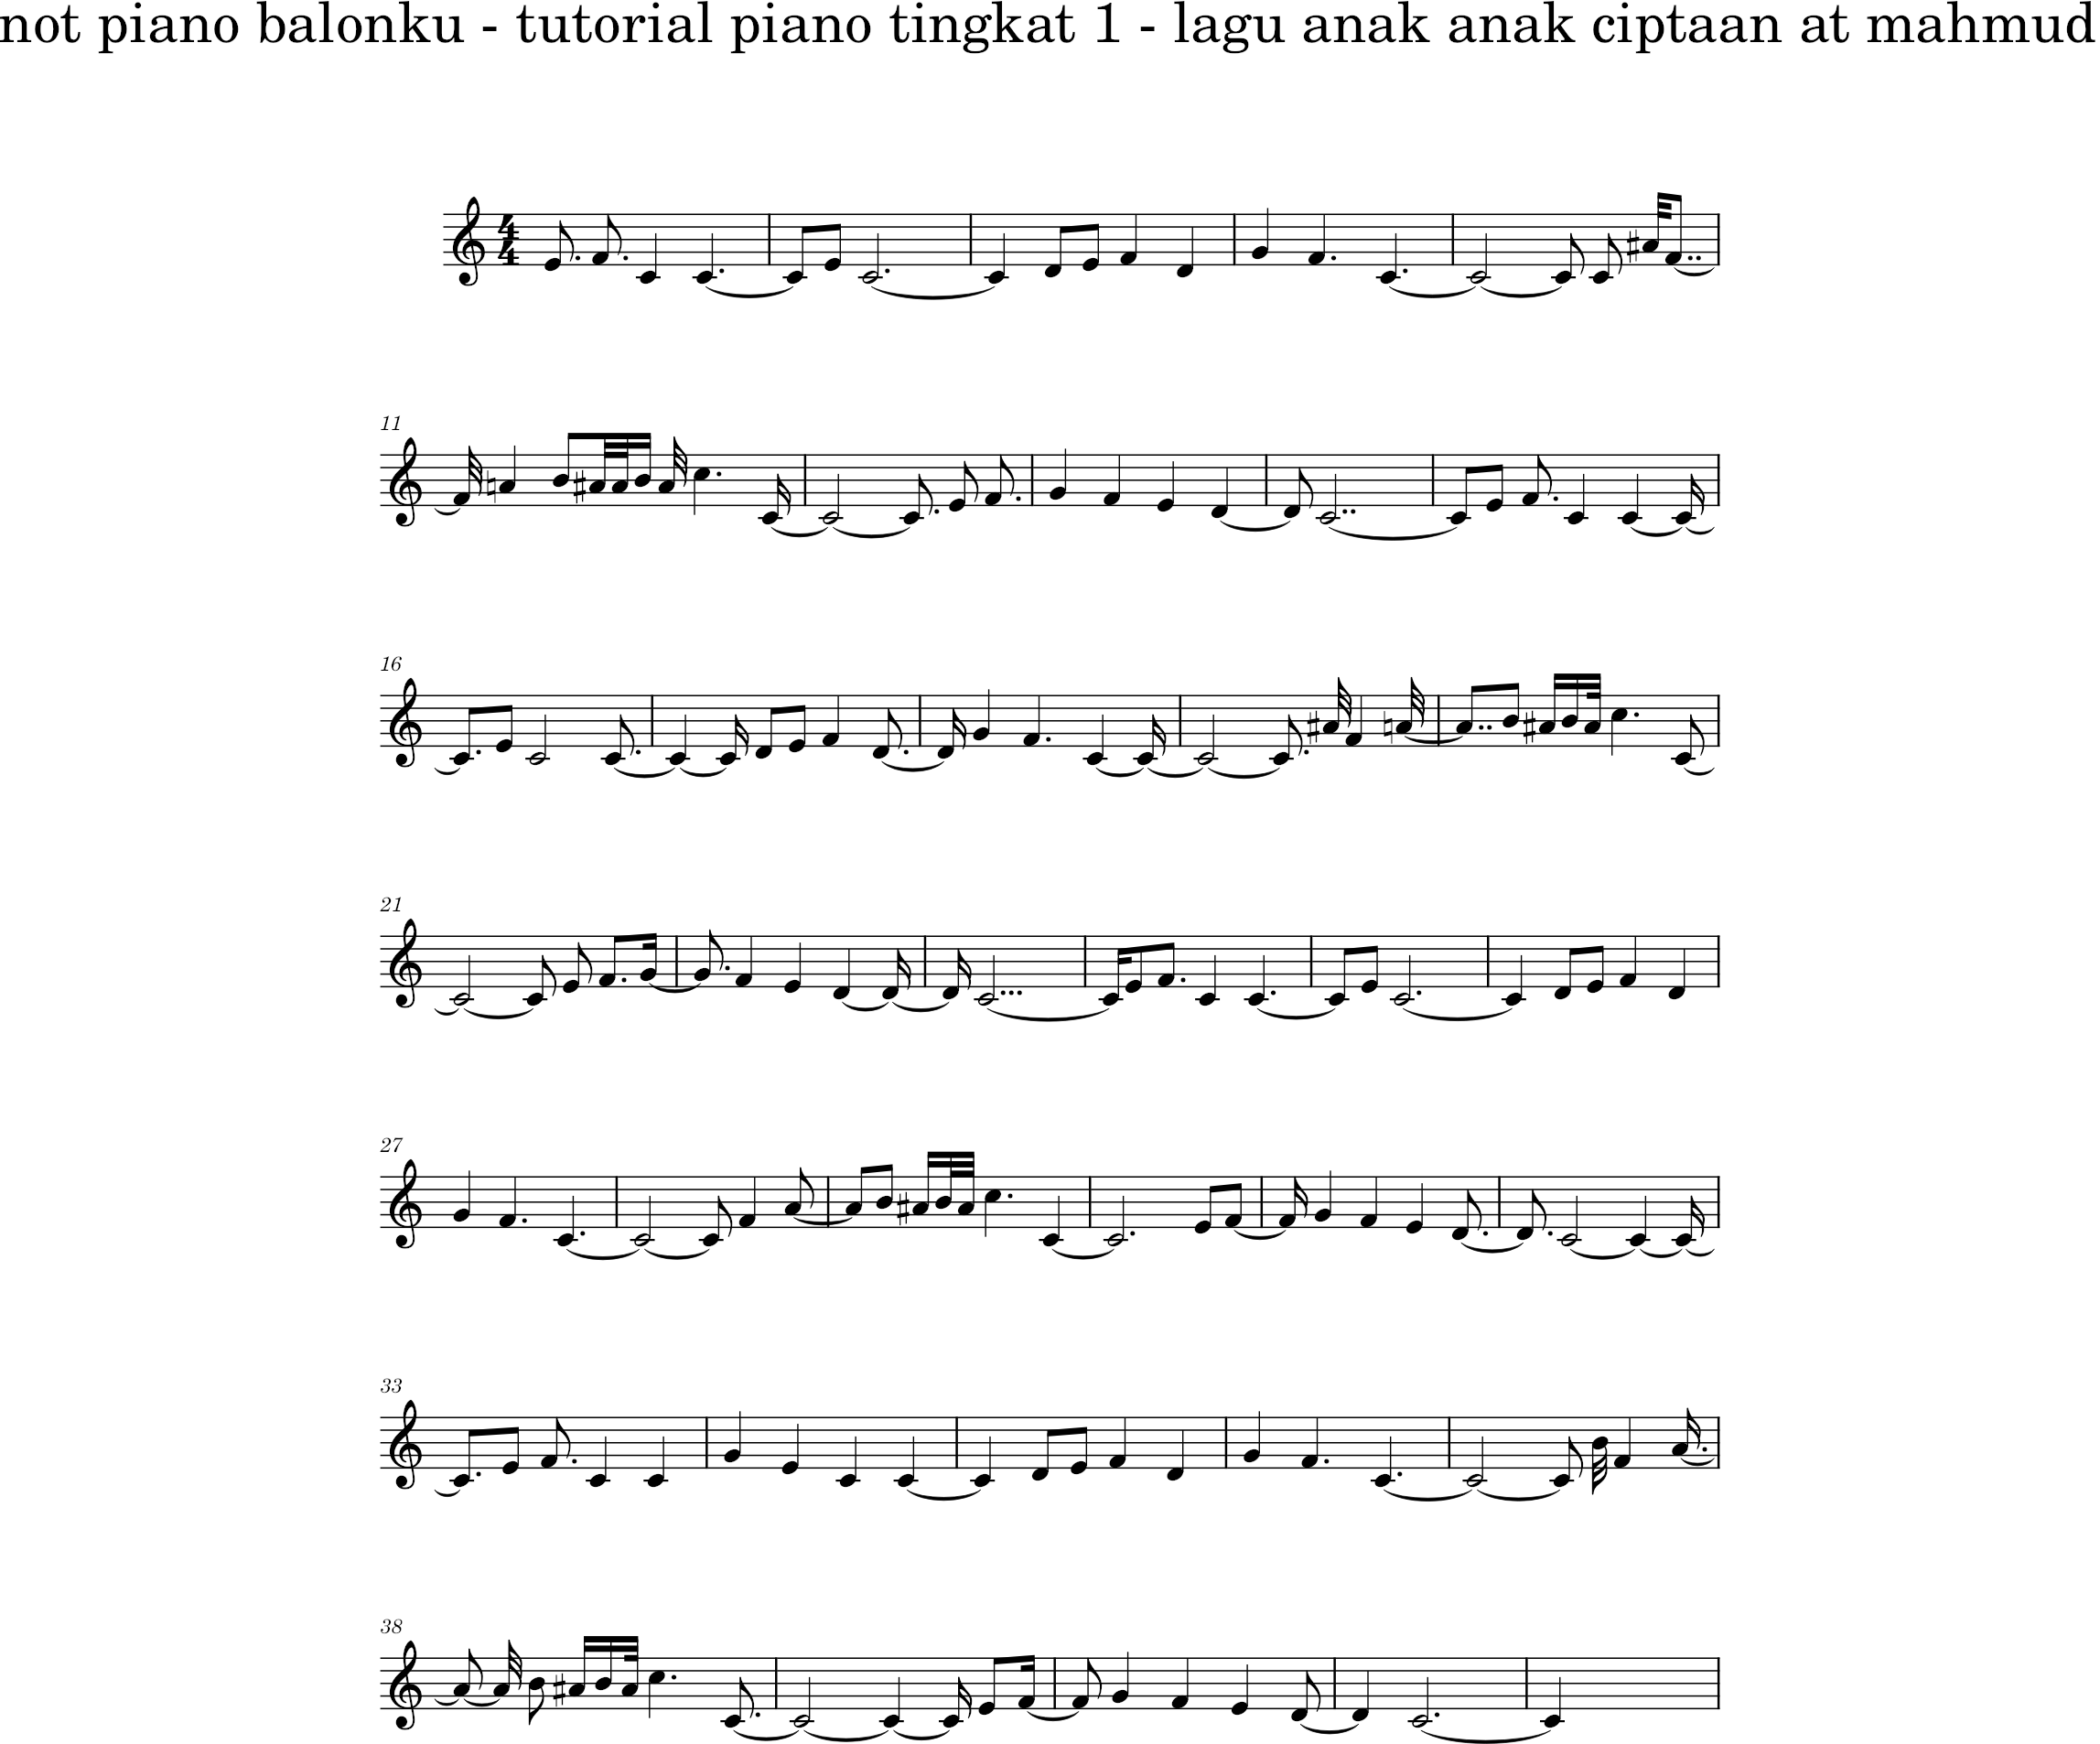

In [70]:
audio_file = "audio/not piano balonku - tutorial piano tingkat 1 - lagu anak anak ciptaan at mahmud.wav"
final_score = process_audio_to_sheet_music(audio_file)
if final_score:
    final_score.show()
